<a href="https://colab.research.google.com/github/donuva/AOM2DF/blob/main/D%E1%BB%B0_%C4%90O%C3%81N_GI%C3%81_TI%E1%BB%80N_%E1%BA%A2O_THETA_COIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=THETA&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

hist.drop(["conversionType", "conversionSymbol"], axis='columns', inplace=True)
hist.head(2001)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


,high,low,open,volumefrom,volumeto,close
time,,,,,,
2018-05-18,0.2357,0.2081,0.2079,3905218.76,911153.72,0.2333
2018-05-19,0.2450,0.2204,0.2333,3695020.84,839474.45,0.2272
2018-05-20,0.2396,0.2206,0.2265,2635769.18,597535.59,0.2267
2018-05-21,0.2317,0.2074,0.2267,4344198.07,960987.77,0.2212
2018-05-22,0.2076,0.1944,0.2212,5306561.28,1065425.75,0.2008
...,...,...,...,...,...,...
2023-11-04,0.7762,0.7461,0.7528,16482.28,12500.90,0.7748
2023-11-05,0.7987,0.7687,0.7748,33259.67,26148.79,0.7938
2023-11-06,0.8288,0.7810,0.7938,32414.31,26005.61,0.8213


In [ ]:
excel_file_path = 'theta_price_history.xlsx'
hist.to_excel(excel_file_path, index=True)
print(f'Data đã được lưu vào tệp Excel: {excel_file_path}')

Data đã được lưu vào tệp Excel: theta_price_history.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#chia bộ dữ liệu tỉ lệ 80% train, 20%test
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.2)

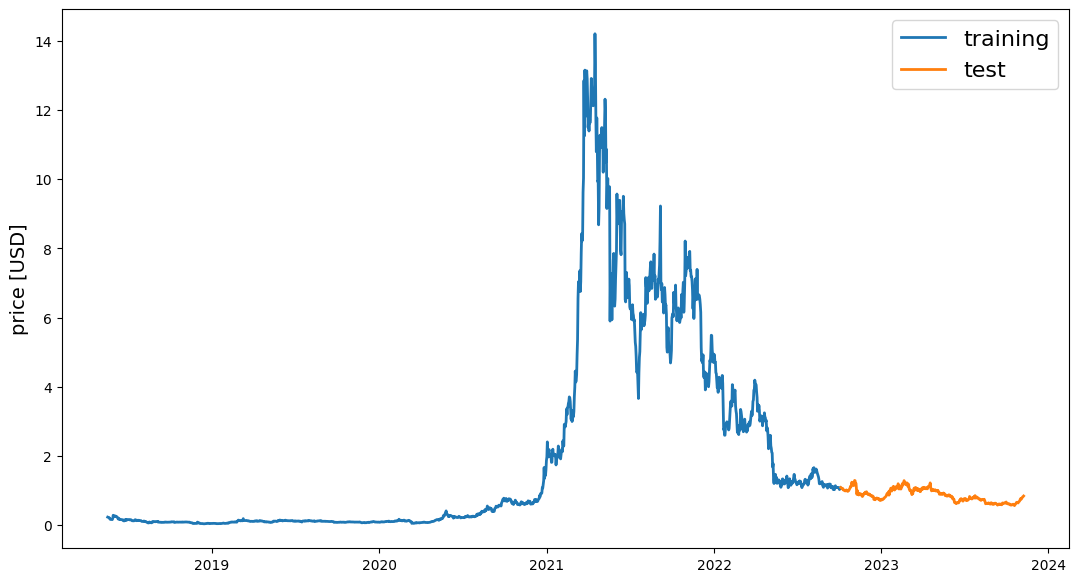

In [ ]:
#vẽ bộ dữ liệu
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

line_plot(train[target_col], test[target_col], 'training', 'test', title='')

Kích thước mẫu: 1601


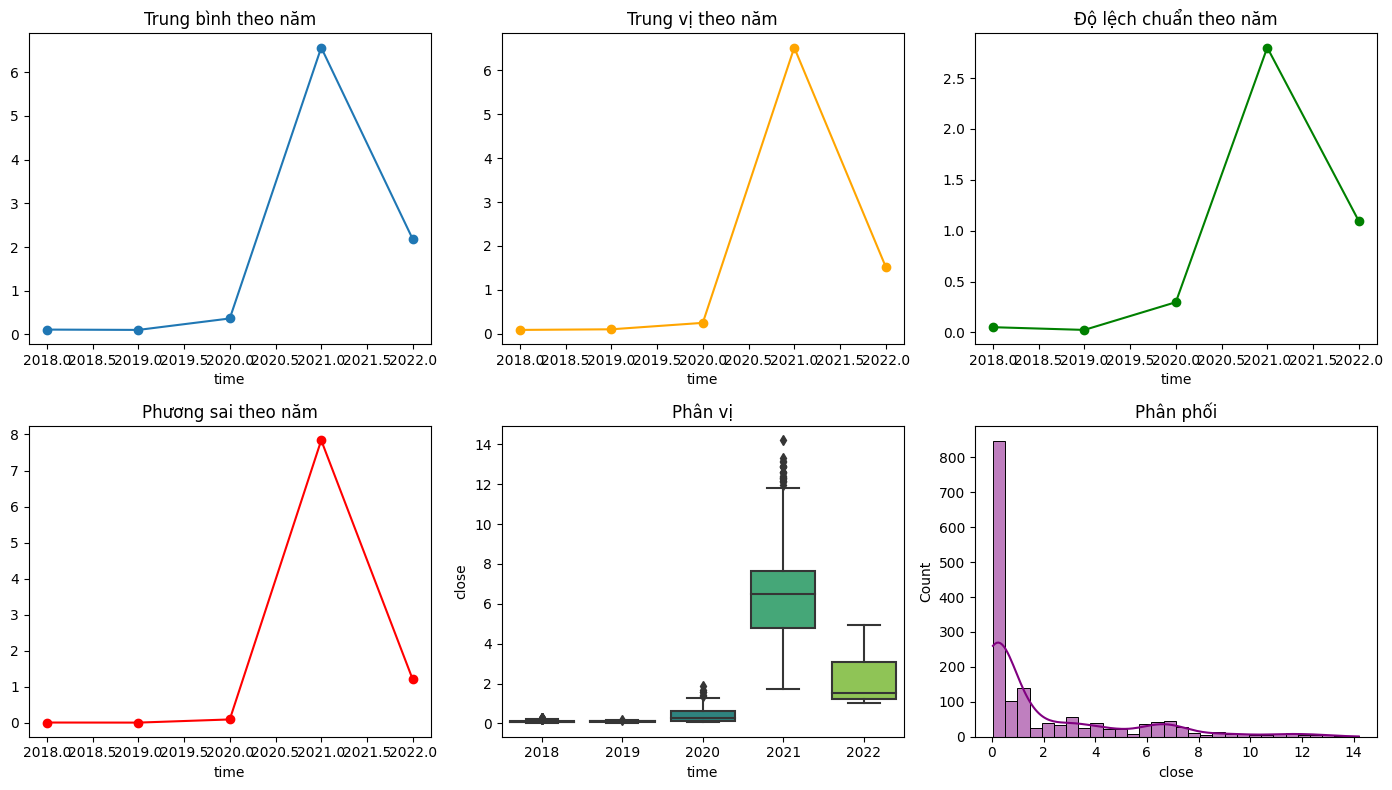

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_statistics_by_year(data, target_col):
    # Nhóm dữ liệu theo năm
    data_by_year = data.groupby(data.index.year)

    # Kích thước mẫu
    print(f'Kích thước mẫu: {len(data)}')

    # Vẽ biểu đồ trung bình, trung vị, độ lệch chuẩn, phương sai, phân vị và phân phối theo năm
    plt.figure(figsize=(14, 8))

    # Trung bình
    plt.subplot(2, 3, 1)
    data_by_year[target_col].mean().plot(marker='o')
    plt.title('Trung bình theo năm')

    # Trung vị
    plt.subplot(2, 3, 2)
    data_by_year[target_col].median().plot(marker='o', color='orange')
    plt.title('Trung vị theo năm')

    # Độ lệch chuẩn
    plt.subplot(2, 3, 3)
    data_by_year[target_col].std().plot(marker='o', color='green')
    plt.title('Độ lệch chuẩn theo năm')

    # Phương sai
    plt.subplot(2, 3, 4)
    data_by_year[target_col].var().plot(marker='o', color='red')
    plt.title('Phương sai theo năm')

    # Phân vị
    plt.subplot(2, 3, 5)
    sns.boxplot(x=data.index.year, y=data[target_col], palette='viridis')
    plt.title('Phân vị')

    # Phân phối
    plt.subplot(2, 3, 6)
    sns.histplot(data[target_col], bins=30, kde=True, color='purple')
    plt.title('Phân phối')

    plt.tight_layout()
    plt.show()

# Sử dụng hàm với dữ liệu train
plot_statistics_by_year(train, target_col)


In [ ]:
#Chuẩn bị data cho mô hình
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
#Mô hình dự đoán sử dụng LSTM
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
#TRAIN DATA
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
50/50 [==============================] - 10s 22ms/step - loss: 0.0137 - val_loss: 0.0024
Epoch 2/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0094 - val_loss: 0.0021
Epoch 3/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0083 - val_loss: 0.0018
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 5/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 8/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 9/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 10/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0015
Epoch 11/20
50/50

13/13 [==============================] - 1s 3ms/step


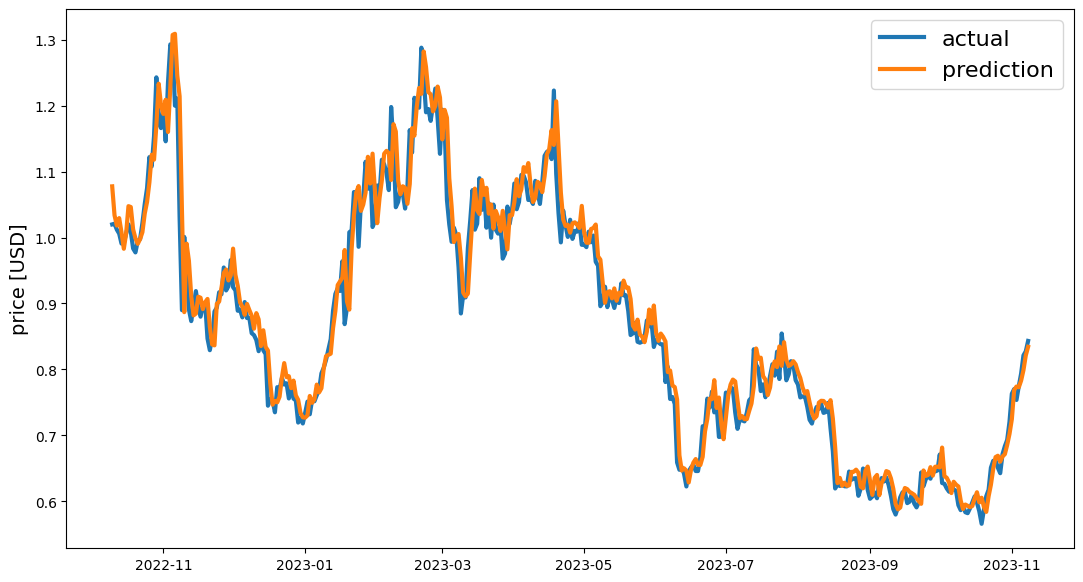

In [ ]:
#VẼ ĐỒ THÌ SO SÁNH GIỮA ĐƯỜNG DỰ ĐOÁN VÀ ĐƯỜNG GIÁ TRỊ THỨC
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
# mean_absolute_error(preds, y_test)
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)